In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

In [0]:
tweet= pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
tweet.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [0]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


In [0]:
# SOME INFO

Text(0, 0.5, 'samples')

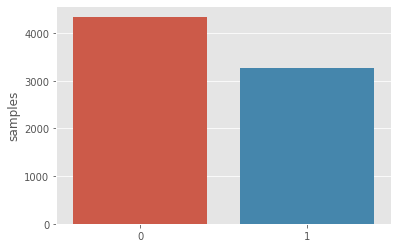

In [0]:
x=tweet.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

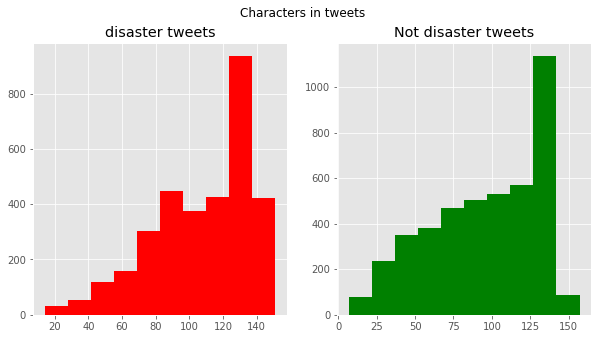

In [0]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

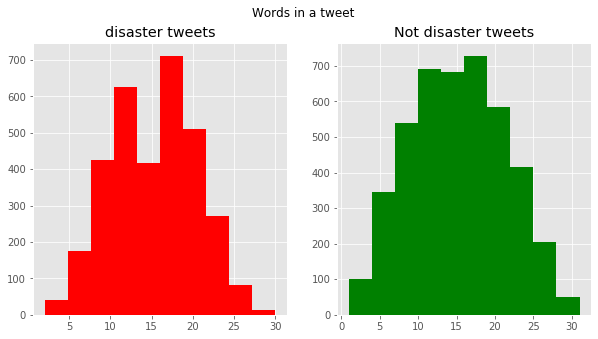

In [0]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

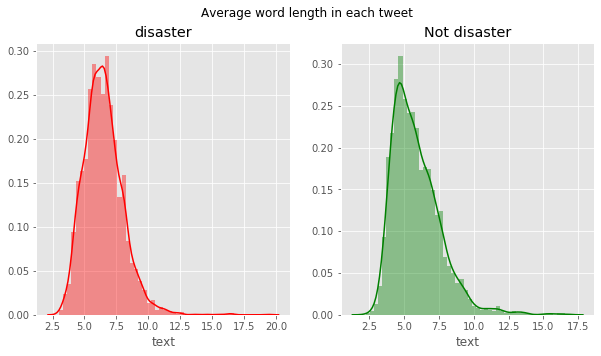

In [0]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [0]:
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [0]:
corpus=create_corpus(0)


In [0]:
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

<BarContainer object of 10 artists>

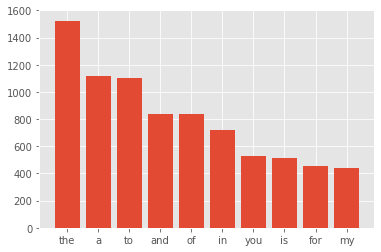

In [0]:
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

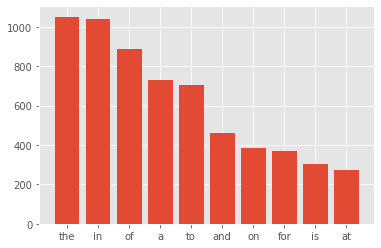

In [0]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    


x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 18 artists>

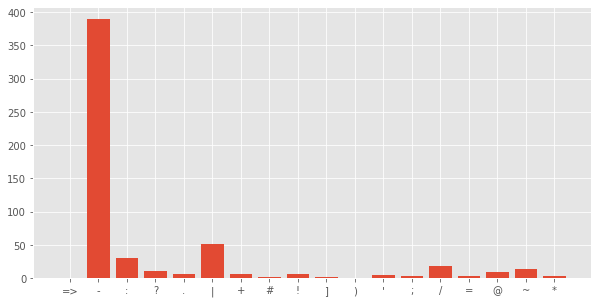

In [0]:
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 20 artists>

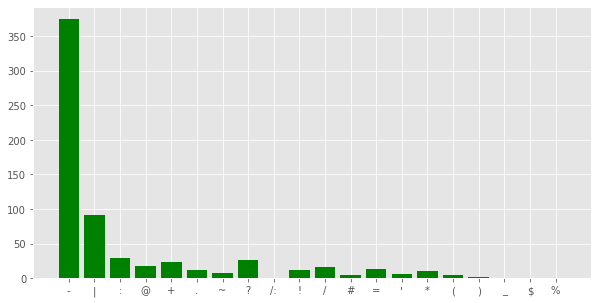

In [0]:
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

In [0]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

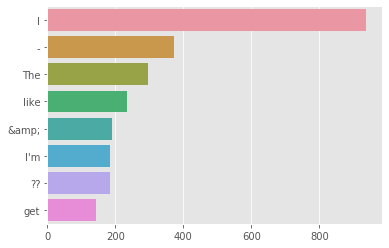

In [0]:
sns.barplot(x=y,y=x)


In [0]:
#NGRAM

In [0]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

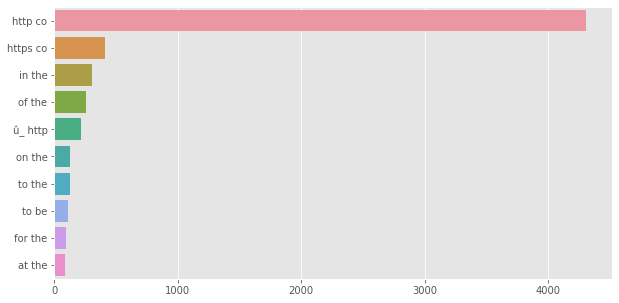

In [0]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [0]:
# Data Cleaning

In [0]:
df=pd.concat([tweet,test])
df.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(10876, 5)

In [0]:
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [0]:
df['text']=df['text'].apply(lambda x : remove_URL(x))


In [0]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [0]:
df['text']=df['text'].apply(lambda x : remove_html(x))

In [0]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [0]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))


In [0]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

I am a king


In [0]:
df['text']=df['text'].apply(lambda x : remove_punct(x))


In [0]:
!pip install pyspellchecker


In [0]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "corect me plese"
correct_spellings(text)

'correct me please'

In [0]:
#df['text']=df['text'].apply(lambda x : correct_spellings(x))
# very time consuming

In [0]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [0]:
corpus=create_corpus(df)


100%|██████████| 10876/10876 [00:01<00:00, 7466.78it/s]


In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-03-11 18:19:20--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-03-11 18:19:21--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-03-11 18:19:21--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
!unzip glove\.\6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
embedding_dict={}
with open('glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [0]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [0]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20342


In [0]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 20342/20342 [00:00<00:00, 506798.45it/s]


In [0]:
##

#
#
#
#
# MODEL1 

In [0]:
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]

In [0]:
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [0]:
sample_sub=pd.read_csv('sample_submission.csv')

def predict_kaggle(model):
  y_pre=model.predict(test)
  y_pre=np.round(y_pre).astype(int).reshape(3263)
  sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
  sub.to_csv('submission.csv',index=False)

In [0]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(lr=1e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [0]:
model.summary()


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 50, 100)           2034300   
_________________________________________________________________
spatial_dropout1d_12 (Spatia (None, 50, 100)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 2,159,869
Trainable params: 125,569
Non-trainable params: 2,034,300
_________________________________________________________________


In [0]:
history=model.fit(X_train,y_train,batch_size=64,epochs=15,validation_data=(X_test,y_test),verbose=1)

Train on 6471 samples, validate on 1142 samples
Epoch 1/15
6471/6471 [==============================] - 14s 2ms/step - loss: 0.6794 - acc: 0.5804 - val_loss: 0.5601 - val_acc: 0.7609
Epoch 2/15
6471/6471 [==============================] - 12s 2ms/step - loss: 0.5430 - acc: 0.7512 - val_loss: 0.4876 - val_acc: 0.7855
Epoch 3/15
6471/6471 [==============================] - 12s 2ms/step - loss: 0.5221 - acc: 0.7616 - val_loss: 0.4874 - val_acc: 0.7802
Epoch 4/15
6471/6471 [==============================] - 12s 2ms/step - loss: 0.5068 - acc: 0.7753 - val_loss: 0.4811 - val_acc: 0.7785
Epoch 5/15
6471/6471 [==============================] - 12s 2ms/step - loss: 0.5043 - acc: 0.7796 - val_loss: 0.4774 - val_acc: 0.7820
Epoch 6/15
6471/6471 [==============================] - 12s 2ms/step - loss: 0.5000 - acc: 0.7807 - val_loss: 0.4771 - val_acc: 0.7828
Epoch 7/15
6471/6471 [==============================] - 12s 2ms/step - loss: 0.5046 - acc: 0.7755 - val_loss: 0.4740 - val_acc: 0.7872
Epoch 8

In [0]:
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


#optimzer=Adam(lr=1e-5)
optimzer=Adam()

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [0]:
model.summary()


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 50, 100)           2034300   
_________________________________________________________________
spatial_dropout1d_14 (Spatia (None, 50, 100)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 2,127,101
Trainable params: 92,801
Non-trainable params: 2,034,300
_________________________________________________________________


In [0]:
history=model.fit(X_train,y_train,batch_size=128,epochs=15,validation_data=(X_test,y_test),verbose=1)

Train on 6471 samples, validate on 1142 samples
Epoch 1/15
6471/6471 [==============================] - 16s 2ms/step - loss: 0.5555 - acc: 0.7322 - val_loss: 0.4629 - val_acc: 0.7916
Epoch 2/15
6471/6471 [==============================] - 12s 2ms/step - loss: 0.4771 - acc: 0.7840 - val_loss: 0.4639 - val_acc: 0.7846
Epoch 3/15
6471/6471 [==============================] - 12s 2ms/step - loss: 0.4659 - acc: 0.7878 - val_loss: 0.4496 - val_acc: 0.7933
Epoch 4/15
6471/6471 [==============================] - 12s 2ms/step - loss: 0.4574 - acc: 0.7894 - val_loss: 0.4417 - val_acc: 0.7863
Epoch 5/15
6471/6471 [==============================] - 13s 2ms/step - loss: 0.4493 - acc: 0.7952 - val_loss: 0.4426 - val_acc: 0.7933
Epoch 6/15
6471/6471 [==============================] - 12s 2ms/step - loss: 0.4403 - acc: 0.8025 - val_loss: 0.4384 - val_acc: 0.7968
Epoch 7/15
6471/6471 [==============================] - 12s 2ms/step - loss: 0.4463 - acc: 0.7948 - val_loss: 0.4389 - val_acc: 0.7942
Epoch 8

In [0]:
predict_kaggle(model)